# Funções

In [1]:
from filter_datasets import *
import pandas as pd
import json
import collections
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt
import ppx #A Python interface to proteomics data repositories
from pyteomics import mztab
from ete3 import Tree, NodeStyle, TreeStyle, NodeStyle, faces, AttrFace, CircleFace
from ete3 import NCBITaxa
import glob
import urllib.parse
import urllib.request
import uniprot
import requests
from Bio import SeqIO
from io import StringIO
from pandas_profiling import ProfileReport

In [3]:
def download_projects(project_list):
    """
        Download all mztab files as well as creates a directory with all files available for download
        Parameters:
            project_list: list of projects to download
    """
    for projects in project_list:
        print(f"Downloading projetc:{projects}") 
        pride_obj = ppx.PrideProject(
        projects,
        local = os.path.join(os.getcwd(),mztab_storage_folder,f"{projects}")
        )
        pride_obj.download(pride_plants_mztab[projects])
        


In [4]:
def unzip_mztabs(path):
    """
    Unzip all mztba.gz files
    """
    for proj_dir,subdir,files in os.walk(os.path.join(os.getcwd(),mztab_storage_folder)):
        if proj_dir.endswith("/generated"):
           os.system(f"gunzip {os.path.join(proj_dir,'*.gz')}")


In [5]:
def get_allmztab(path):
    """
    Get a list with all mztab files 
    """
    all_files = glob.glob(path)
    return all_files

In [6]:
# usar accession de PSM para pegar description em PRT
def PSM2PRT (mztab,accession):
    """
    Uses mztab["PRT"] accession to get pep sequence description availabel only on mztab["PSM"]
    Parameters:
        mztab: file to search
        accession: accession number
    """   
    for pst_data in mztab["PRT"].itertuples():
            if pst_data.accession == accession:
                return pst_data.description


In [7]:
def resume_mztab(file_list:list,specie ):
    """
        Returns a fasta file, per project, with all peps on all mztabs
        Parameters:
            file_list: list containg mztab files
            specie: specie to name the returning fasta file   
    """
    for files in file_list:
        mztab_obj = mztab.MzTab(files)
        projetc_number  = mztab_obj.metadata["mzTab-ID"]
        with open(f"{specie}_{projetc_number}.fasta","w+") as file_fasta:
            for info in mztab_obj["PSM"].itertuples():
                file_fasta.write(f">{info.accession} | {PSM2PRT(mztab_obj,info.accession)} \n") # Se possível, preciso melhorar isso. O(n²) é lento
                file_fasta.write(f"{info.sequence}\n") 
    return file_fasta

In [21]:
def get_swissprot_sequences(accession:list,out_file_name:str,project):
    """
    convert pride accession number to swissprot accession number then downloads complete protein sequences
        Parameters:
            accession: List containg PRIDE IDs

    """
    databases_url = 'https://www.uniprot.org/uploadlists/'
    query = None
    if len(accession) == 1:
        query = accession
        params = {
        'from': 'ACC+ID', #pride accession
        'to': 'SWISSPROT', #swissprot accession
        'format': 'list',
        'query': f'{query}'}
    else:
        params = {
        'from': 'ACC+ID', #pride accession
        'to': 'SWISSPROT', #swissprot accession
        'format': 'list',
        'query': f'{" ".join(accession)}'}
    pride_accession = urllib.parse.urlencode(params)
    pride_accession = pride_accession.encode('utf-8')
    req = urllib.request.Request(databases_url, pride_accession)
    with urllib.request.urlopen(req) as accession_file:
        response = accession_file.read()
    swissprot_accession = list(response.decode('utf-8').split("\n"))

    
    # Get protein sequences from swissprot
    swissprot_url = "http://www.uniprot.org/uniprot/"
    with open(f"{'_'.join(out_file_name)}_{project}.complete.fasta","w+") as fasta:
        for IDs in swissprot_accession:
            joint_url = swissprot_url + IDs + ".fasta"
            swissprot_response = requests.post(joint_url)
            raw_data = "".join(swissprot_response.text)
            Seq = StringIO(raw_data)
            for seq_info in SeqIO.parse(Seq,'fasta'):
                fasta.write(f">{seq_info.description}\n")
                fasta.write(f"{seq_info.seq}\n")
    return fasta

In [9]:
def concatenate_swissprot(file_list, specie):
    """
    Concatenate get_swissprot_sequences results
    """
    for files in file_list:
        mztab_obj = mztab.MzTab(files)
        project_number  = mztab_obj.metadata["mzTab-ID"]
        accession_list = mztab_obj["PRT"].accession.values
        get_swissprot_sequences(accession_list,specie,project_number)

In [22]:
def download_sequences(mztab_prt,out_file):
    """ """
    project_id  = mztab_prt.metadata["mzTab-ID"]
    with open(f"{os.path.join(out_file,project_id)}.fasta","w+") as sequence_fasta_file:
        for data in mztab_prt["PRT"].itertuples():
            uniprot_url = 'https://www.uniprot.org/uploadlists/'
            params = {
            'from': 'ACC+ID', #swissprot accession
            'to': 'EMBL', #ENA accession
            'format': 'list',
            'query': f'{data.accession}'
            }
            pride_accession = urllib.parse.urlencode(params)
            pride_accession = pride_accession.encode('utf-8')
            pride_request = urllib.request.Request(uniprot_url, pride_accession)
            with urllib.request.urlopen(pride_request) as request_data:
                pride_request_response = request_data.read()
                
            ENA_accession = pride_request_response.decode("utf-8").split('\n')
            ENA_ulr = url = f"https://www.ebi.ac.uk/ena/browser/api/fasta/{ENA_accession[0]}?lineLimit=1000"
            ENA_seq_request = requests.get(url).text.split("\n")
            fasta_id = data.description
            fasta_seq = "".join(ENA_seq_request[1:])
            sequence_fasta_file.write(f">{fasta_id}\n")
            sequence_fasta_file.write(f"{fasta_seq}\n")

# 1. Objetivos
**Geral**: encontrar RNA de plantas tidos como não codificantes mas que, na verdade, codificam proteínas

**Específico**: Varrer os bancos de dados de proteômica em busca de proteínas candidatas a serem codificadas por mRNAs tidos como não codificantes


### 1.1. PRoteomcis IDEntifications Database (PRIDE) [link](https://www.ebi.ac.uk/pride/)

Visão geral do PRIDE

In [11]:
# pride_plant.json foi gerado usando a função filterPride para checar o número de projetos com plantas 
with open('pride_plant.json') as pride_plants_file:
    pride_plant = json.load(pride_plants_file)
print(f"Total de projetos com plantas no PRIDE: {len(pride_plant)}")

Total de projetos com plantas no PRIDE: 1464


In [12]:
pd.DataFrame(pride_plant,).T.head()

,name,accession
PRD000037,Chlamydomonas reinhardtii,3055
PRD000044,Arabidopsis thaliana (mouse-ear cress),3702
PRD000051,Zea mays (maize),4577
PRD000084,Arabidopsis thaliana (mouse-ear cress),3702
PRD000096,Arabidopsis thaliana (mouse-ear cress),3702


In [13]:
# Pride_plants_mztab.json foi gerado usando a função get_mztabes. Ele contem os projetos com plantas e com arquivos mztab
with open("pride_plants_mztab.json") as mztabs:
    pride_plants_mztab = json.load(mztabs)
print(f"Total de projetos com arquivos mztab: {len(pride_plants_mztab)}")

Total de projetos com arquivos mztab: 270


In [20]:
def get_projects(dict_plants = pride_plant, dict_mztab = pride_plants_mztab, specie = None):
    """
    Returns all projecst with mztab files for a give plant specie. Search by name
    parameters:
        dict_plants: contains all plant projects retrivied from PRIDE
        pride_plants_mztab: contains all plant projects with mztab retrivied from PRIDE
        specie: specie's name to search
    """
    projetcs_total = [projects for projects,values in dict_plants.items() if f"{specie}" in values["name"]]
    projects = list(set(dict_mztab.keys()) & set(projetcs_total))
    return projects

Arquivos mztab por espécie

In [14]:
pride_plants_names = [values["name"] for keys,values in pride_plant.items()]
pride_plants_counter = collections.Counter(pride_plants_names)
plant_names = [plants[0] for plants in pride_plants_counter.items()]
plant_quant = [plants[1] for plants in pride_plants_counter.items()]
plant_with_mztab = [] 
for specie in pride_plants_counter.keys():
    all_projects = [projects for projects,values in pride_plant.items() if f"{specie}" == values["name"]]
    mztab_projects = list(set(pride_plants_mztab.keys()) & set(all_projects))
    plant_with_mztab.append(len(mztab_projects))
plants_count_dataframe = pd.DataFrame({
    "Specie":plant_names,
    "Total_projects":plant_quant,
    "Projects_with_mztab":plant_with_mztab
})
plants_count_dataframe.sort_values("Total_projects", ascending = False, inplace = True)


In [16]:
plants_count_dataframe

,Specie,Total_projects,Projects_with_mztab
1,Arabidopsis thaliana (mouse-ear cress),490,110
45,Triticum aestivum (wheat),73,11
18,Rice(o. sativa),58,10
2,Zea mays (maize),57,7
0,Chlamydomonas reinhardtii,50,12
...,...,...,...
129,Micromonas sp. (strain rcc299 / noum17) (picop...,1,1
130,Zingiber officinale,1,0
133,Leymus chinensis,1,0
134,Cannabis,1,1


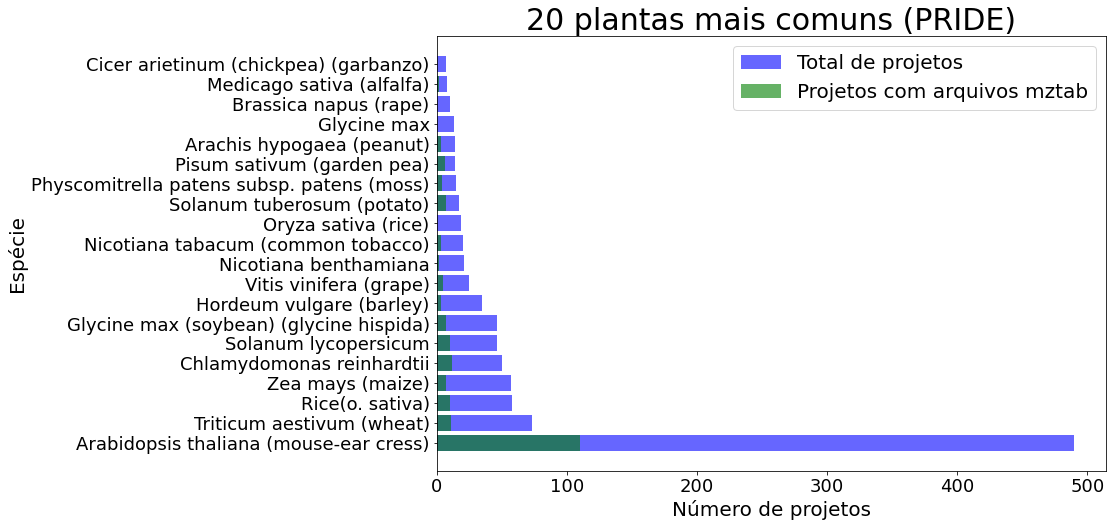

In [28]:
plt.figure(figsize = (12,8))
plot = plt.subplot()
projects = plot.barh(plants_count_dataframe.Specie[:20],plants_count_dataframe.Total_projects[:20],color = 'b',align='center', alpha = .6)
mztabs = plot.barh(plants_count_dataframe.Specie[:20],plants_count_dataframe.Projects_with_mztab[:20],color = 'g',align='center', alpha = 0.6,)
plot.set_ylabel("Espécie",fontsize = 20)
plot.set_xlabel("Número de projetos",fontsize = 20)
plot.set_title("20 plantas mais comuns (PRIDE)", fontsize = 30)
plot.tick_params(labelsize = 18)
plot.legend((projects,mztabs),("Total de projetos","Projetos com arquivos mztab"),fontsize = 20)
plt.savefig("/home/tiago/documents/lncRNA/figures/most_commum.png")


### 3. Caminhos possíveis 

1. Os arquivos do PRIDE contem peptídeos que fazem parte de proteínas não caracterizadas e que podem ser mapeadas de volta em regiões codificam RNAs não codificantes nos genomas das espécias alvo.

2. Os arquivos do PRIDE contem peptídeos qua não estão nos proteoma das espécies alvo.


![Fluxograma](figures/fluxograma.jpg)

# Resultados

### *Coffea arabica*

Criar diretório onde os arquivos e resultados serão armazenados

In [18]:
import os
mztab_storage_folder = "C.arabica2"
try:
    os.makedirs(os.path.join(os.getcwd(),mztab_storage_folder))
except:
    print(f"Folder already exist: {os.path.join(os.getcwd(),mztab_storage_folder)}")

In [19]:
#Dowload all gene sequences of proteome in PRIde mztab files
specie = "Coffea arabica"
projects = get_projects(specie = specie) # Find PRIDE projects for a given specie
download_projects(projects) #Download all projects 
unzip_mztabs(path = os.path.join(os.getcwd(),mztab_storage_folder))
for proj_dir,subdir,files in os.walk(os.path.join(os.getcwd(),mztab_storage_folder)):
    if proj_dir.endswith("/generated"):
        all_mztab_files = get_allmztab(os.path.join(proj_dir,"*.mztab")) #Concatenate all mztabs by projetc
        for mztab_path in all_mztab_files:
            mztab_obj = mztab.MzTab(mztab_path) #Creat mztab object
            print(proj_dir.split("/")[-2])
            download_sequences(mztab_obj,proj_dir) #Crossref between Uniprot/Swissprot and ncbi

NameError: name 'get_projects' is not defined

## Em andamento

### Soy bean

In [94]:
mztab_storage_folder = "G.max"
try:
    os.makedirs(os.path.join(os.getcwd(),mztab_storage_folder))
except:
    print(f"Folder already exist: {os.path.join(os.getcwd(),mztab_storage_folder)}")

Folder already exist: /home/tiago/documents/lncRNA/G.max


In [96]:
specie = "Glycine max"
projects = get_projects(specie = specie)
print(f"Total of projects for {specie}:{len(projects)}")
download_projects(projects)
unzip_mztabs(path = os.path.join(os.getcwd(),mztab_storage_folder))
for proj_dir,subdir,files in os.walk(os.path.join(os.getcwd(),mztab_storage_folder)):
    if proj_dir.endswith("/generated"):
        all_mztab_files = get_allmztab(os.path.join(proj_dir,"*.mztab"))
        for mztab_path in all_mztab_files:
            mztab_obj = mztab.MzTab(mztab_path)
            print(proj_dir.split("/")[-2])
            download_sequences(mztab_obj,proj_dir) 

Total of projects for Glycine max:7


TOTAL:   0%|          | 0/137 [00:00<?, ?files/s]

generated/SoySEC_standards_02a_03132018.MSGF+.pride.mztab.gz:   0%|          | 0.00/14.5M [00:00<?, ?b/s]

generated/SoySEC_standards_03a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.3M [00:00<?, ?b/s]

generated/SoySEC_standards_04a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.7M [00:00<?, ?b/s]

generated/SoySEC_standards_06a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/15.8M [00:00<?, ?b/s]

generated/SoySEC_standards_07a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/14.2M [00:00<?, ?b/s]

generated/SoySEC_standards_08a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/15.4M [00:00<?, ?b/s]

generated/SoySEC_standards_09a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/15.6M [00:00<?, ?b/s]

generated/SoySEC_standards_10a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.7M [00:00<?, ?b/s]

generated/SoySEC_standards_11a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.3M [00:00<?, ?b/s]

generated/SoySEC_standards_12a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/15.7M [00:00<?, ?b/s]

generated/SoySEC_standards_13a_03132018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.2M [00:00<?, ?b/s]

generated/SoySEC_standards_14a_03132018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.2M [00:00<?, ?b/s]

generated/SoySEC_standards_15a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.4M [00:00<?, ?b/s]

generated/SoySEC_standards_16a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/15.6M [00:00<?, ?b/s]

generated/SoySEC_standards_17a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/17.2M [00:00<?, ?b/s]

generated/SoySEC_standards_18a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/17.3M [00:00<?, ?b/s]

generated/SoySEC_standards_19a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/17.6M [00:00<?, ?b/s]

generated/SoySEC_standards_20a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/14.7M [00:00<?, ?b/s]

generated/SoySEC_standards_21a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/13.5M [00:00<?, ?b/s]

generated/SoySEC_standards_22a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.1M [00:00<?, ?b/s]

generated/SoySEC_standards_23a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/19.3M [00:00<?, ?b/s]

generated/SoySEC_standards_24a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/19.4M [00:00<?, ?b/s]

generated/SoySEC_standards_25a_03132018.MSGF+.pride.mztab.gz:   0%|          | 0.00/18.2M [00:00<?, ?b/s]

generated/SoySEC_standards_26a_03132018.MSGF+.pride.mztab.gz:   0%|          | 0.00/18.3M [00:00<?, ?b/s]

generated/SoySEC_standards_27a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/18.6M [00:00<?, ?b/s]

generated/SoySEC_standards_28a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/17.3M [00:00<?, ?b/s]

generated/SoySEC_standards_29a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/18.0M [00:00<?, ?b/s]

generated/SoySEC_standards_30a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/17.4M [00:00<?, ?b/s]

generated/SoySEC_standards_31a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/17.8M [00:00<?, ?b/s]

generated/SoySEC_standards_32a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/17.3M [00:00<?, ?b/s]

generated/SoySEC_standards_33a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.3M [00:00<?, ?b/s]

generated/SoySEC_standards_34a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.3M [00:00<?, ?b/s]

generated/SoySEC_standards_35a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/16.6M [00:00<?, ?b/s]

generated/SoySEC_standards_36a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/15.1M [00:00<?, ?b/s]

generated/SoySEC_standards_37a_03132018.MSGF+.pride.mztab.gz:   0%|          | 0.00/15.4M [00:00<?, ?b/s]

generated/SoySEC_standards_38a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/14.4M [00:00<?, ?b/s]

generated/SoySEC_standards_39a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/14.3M [00:00<?, ?b/s]

generated/SoySEC_standards_40a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/13.4M [00:00<?, ?b/s]

generated/SoySEC_standards_41a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/12.8M [00:00<?, ?b/s]

generated/SoySEC_standards_42a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/13.0M [00:00<?, ?b/s]

generated/SoySEC_standards_43a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/12.2M [00:00<?, ?b/s]

generated/SoySEC_standards_44a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/12.3M [00:00<?, ?b/s]

generated/SoySEC_standards_45a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/12.2M [00:00<?, ?b/s]

generated/SoySEC_standards_46a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/13.6M [00:00<?, ?b/s]

generated/SoySEC_standards_47a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/13.0M [00:00<?, ?b/s]

generated/SoySEC_standards_48a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/13.1M [00:00<?, ?b/s]

generated/SoySEC_standards_49a_03132018.MSGF+.pride.mztab.gz:   0%|          | 0.00/12.4M [00:00<?, ?b/s]

generated/SoySEC_standards_50a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.28M [00:00<?, ?b/s]

generated/SoySEC_standards_51a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/11.5M [00:00<?, ?b/s]

generated/SoySEC_standards_52a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.8M [00:00<?, ?b/s]

generated/SoySEC_standards_53a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/11.0M [00:00<?, ?b/s]

generated/SoySEC_standards_54a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/7.19M [00:00<?, ?b/s]

generated/SoySEC_standards_55a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/11.8M [00:00<?, ?b/s]

generated/SoySEC_standards_56a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/11.2M [00:00<?, ?b/s]

generated/SoySEC_standards_57a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.1M [00:00<?, ?b/s]

generated/SoySEC_standards_58a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.66M [00:00<?, ?b/s]

generated/SoySEC_standards_59a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.5M [00:00<?, ?b/s]

generated/SoySEC_standards_60a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.7M [00:00<?, ?b/s]

generated/SoySEC_standards_61a_03132018.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.1M [00:00<?, ?b/s]

generated/SoySEC_standards_62a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.4M [00:00<?, ?b/s]

generated/SoySEC_standards_63a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.4M [00:00<?, ?b/s]

generated/SoySEC_standards_64a_03142018.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.68M [00:00<?, ?b/s]

generated/SoySEC_standards_65a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/11.4M [00:00<?, ?b/s]

generated/SoySEC_standards_66a_03152018.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.2M [00:00<?, ?b/s]

generated/SoySEC_standards_67a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.56M [00:00<?, ?b/s]

generated/SoySEC_standards_68a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.8M [00:00<?, ?b/s]

generated/SoySEC_standards_69a_03162018.MSGF+.pride.mztab.gz:   0%|          | 0.00/11.2M [00:00<?, ?b/s]

generated/SoySEC_standards_70a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.03M [00:00<?, ?b/s]

generated/SoySEC_standards_71a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/11.9M [00:00<?, ?b/s]

generated/SoySEC_standards_72a_03172018.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.61M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_03_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.91M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_04_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.4M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_05_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.91M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_06_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.26M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_07_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/7.99M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_08_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/7.81M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_09_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/7.90M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_10_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.05M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_11_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/7.92M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_12_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.01M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_13_1a_10202017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.07M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_14_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.24M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_15_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.36M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_16_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.11M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_17_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.49M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_18_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.00M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_19_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/6.41M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_20_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/6.96M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_21_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.22M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_22_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.15M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_23_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.87M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_24_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.72M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_25_1a_10202017.MSGF+.pride.mztab.gz:   0%|          | 0.00/10.0M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_26_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.75M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_27_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.57M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_28_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.32M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_29_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.79M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_30_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.54M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_31_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.75M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_32_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.55M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_33_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.35M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_34_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.99M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_35_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.03M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_36_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.59M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_37_1a_10202017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.11M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_38_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/9.00M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_39_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.33M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_40_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/8.11M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_41_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/6.52M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_42_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/6.83M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_43_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/6.89M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_44_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/6.38M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_45_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/6.09M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_46_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/5.04M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_47_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/4.98M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_48_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.85M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_49_1a_10202017.MSGF+.pride.mztab.gz:   0%|          | 0.00/5.48M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_50_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/5.23M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_51_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/4.90M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_52_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/4.59M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_53_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/4.60M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_54_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/4.26M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_55_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/4.19M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_56_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/4.08M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_57_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.05M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_58_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.02M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_59_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/2.89M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_60_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/4.10M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_61_1a_10202017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.61M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_62_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.19M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_63_1a_10212017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.15M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_64_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.13M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_65_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.04M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_66_1a_10222017.MSGF+.pride.mztab.gz:   0%|          | 0.00/2.86M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_67_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.37M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_68_1a_10232017.MSGF+.pride.mztab.gz:   0%|          | 0.00/3.08M [00:00<?, ?b/s]

generated/Soy_sprout_SEC_69_1a_10242017.MSGF+.pride.mztab.gz:   0%|          | 0.00/2.17M [00:00<?, ?b/s]

TOTAL:   0%|          | 0/24 [00:00<?, ?files/s]

generated/PRIDE_Exp_Complete_Ac_28646.pride.mztab.gz:   0%|          | 0.00/343k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28647.pride.mztab.gz:   0%|          | 0.00/414k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28648.pride.mztab.gz:   0%|          | 0.00/411k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28649.pride.mztab.gz:   0%|          | 0.00/366k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28650.pride.mztab.gz:   0%|          | 0.00/401k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28651.pride.mztab.gz:   0%|          | 0.00/384k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28652.pride.mztab.gz:   0%|          | 0.00/455k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28653.pride.mztab.gz:   0%|          | 0.00/384k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28654.pride.mztab.gz:   0%|          | 0.00/362k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28655.pride.mztab.gz:   0%|          | 0.00/445k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28656.pride.mztab.gz:   0%|          | 0.00/346k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28657.pride.mztab.gz:   0%|          | 0.00/396k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28658.pride.mztab.gz:   0%|          | 0.00/458k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28659.pride.mztab.gz:   0%|          | 0.00/446k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28660.pride.mztab.gz:   0%|          | 0.00/451k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28661.pride.mztab.gz:   0%|          | 0.00/462k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28662.pride.mztab.gz:   0%|          | 0.00/431k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28663.pride.mztab.gz:   0%|          | 0.00/441k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28664.pride.mztab.gz:   0%|          | 0.00/480k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28665.pride.mztab.gz:   0%|          | 0.00/442k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28666.pride.mztab.gz:   0%|          | 0.00/446k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28667.pride.mztab.gz:   0%|          | 0.00/453k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28668.pride.mztab.gz:   0%|          | 0.00/463k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28669.pride.mztab.gz:   0%|          | 0.00/447k [00:00<?, ?b/s]

TOTAL:   0%|          | 0/30 [00:00<?, ?files/s]

generated/Xtandem_results.G1_D.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.G1_S.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.G1_Tr.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.G1_Tw.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.G1_U.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.G2_D.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.G2_S.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.G2_Tr.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.G2_Tw.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.G2_U.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.G3_D.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.G3_S.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.G3_Tr.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.G3_Tw.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.G3_U.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.O1_D.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.O1_S.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.O1_Tr.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.O1_Tw.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.O1_U.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.O2_D.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.O2_S.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.O2_Tr.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.O2_Tw.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.O2_U.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.O3_D.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.O3_S.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

generated/Xtandem_results.O3_Tr.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.O3_Tw.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|       …

generated/Xtandem_results.O3_U.mgf.Glycine_max_RefSeq_proteins_BC.fasta-filtered.pride.mztab.gz:   0%|        …

TOTAL:   0%|          | 0/15 [00:00<?, ?files/s]

generated/PRIDE_Exp_Complete_Ac_29517.pride.mztab.gz:   0%|          | 0.00/352k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29518.pride.mztab.gz:   0%|          | 0.00/383k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29519.pride.mztab.gz:   0%|          | 0.00/370k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29520.pride.mztab.gz:   0%|          | 0.00/377k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29521.pride.mztab.gz:   0%|          | 0.00/417k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29522.pride.mztab.gz:   0%|          | 0.00/324k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29523.pride.mztab.gz:   0%|          | 0.00/326k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29524.pride.mztab.gz:   0%|          | 0.00/263k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29525.pride.mztab.gz:   0%|          | 0.00/262k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29526.pride.mztab.gz:   0%|          | 0.00/473k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29527.pride.mztab.gz:   0%|          | 0.00/465k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29528.pride.mztab.gz:   0%|          | 0.00/468k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29529.pride.mztab.gz:   0%|          | 0.00/351k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29530.pride.mztab.gz:   0%|          | 0.00/339k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29531.pride.mztab.gz:   0%|          | 0.00/334k [00:00<?, ?b/s]

TOTAL:   0%|          | 0/12 [00:00<?, ?files/s]

generated/Xtandem_results.WT_1.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab.gz…

generated/Xtandem_results.WT_2.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab.gz…

generated/Xtandem_results.WT_3.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab.gz…

generated/Xtandem_results.line4_1.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab…

generated/Xtandem_results.line4_2.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab…

generated/Xtandem_results.line4_3.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab…

generated/Xtandem_results.line5_1.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab…

generated/Xtandem_results.line5_2.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab…

generated/Xtandem_results.line5_3.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab…

generated/Xtandem_results.line6_1.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab…

generated/Xtandem_results.line6_2.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab…

generated/Xtandem_results.line6_3.mgf.Glycine_max_RefSeq_proteins_with_BC_HGF_combined.fa-filtered.pride.mztab…

TOTAL:   0%|          | 0/90 [00:00<?, ?files/s]

generated/PRIDE_Exp_Complete_Ac_28967.pride.mztab.gz:   0%|          | 0.00/205k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28968.pride.mztab.gz:   0%|          | 0.00/225k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28969.pride.mztab.gz:   0%|          | 0.00/213k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28970.pride.mztab.gz:   0%|          | 0.00/232k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28971.pride.mztab.gz:   0%|          | 0.00/213k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28972.pride.mztab.gz:   0%|          | 0.00/224k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28973.pride.mztab.gz:   0%|          | 0.00/183k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28974.pride.mztab.gz:   0%|          | 0.00/201k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28975.pride.mztab.gz:   0%|          | 0.00/201k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28976.pride.mztab.gz:   0%|          | 0.00/209k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28977.pride.mztab.gz:   0%|          | 0.00/194k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28978.pride.mztab.gz:   0%|          | 0.00/216k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28979.pride.mztab.gz:   0%|          | 0.00/179k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28980.pride.mztab.gz:   0%|          | 0.00/213k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28981.pride.mztab.gz:   0%|          | 0.00/186k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28982.pride.mztab.gz:   0%|          | 0.00/223k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28983.pride.mztab.gz:   0%|          | 0.00/195k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28984.pride.mztab.gz:   0%|          | 0.00/219k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28985.pride.mztab.gz:   0%|          | 0.00/205k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28986.pride.mztab.gz:   0%|          | 0.00/220k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28987.pride.mztab.gz:   0%|          | 0.00/206k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28988.pride.mztab.gz:   0%|          | 0.00/216k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28989.pride.mztab.gz:   0%|          | 0.00/207k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28990.pride.mztab.gz:   0%|          | 0.00/224k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28991.pride.mztab.gz:   0%|          | 0.00/271k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28992.pride.mztab.gz:   0%|          | 0.00/252k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28993.pride.mztab.gz:   0%|          | 0.00/258k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28994.pride.mztab.gz:   0%|          | 0.00/258k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28995.pride.mztab.gz:   0%|          | 0.00/275k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28996.pride.mztab.gz:   0%|          | 0.00/270k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28997.pride.mztab.gz:   0%|          | 0.00/264k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28998.pride.mztab.gz:   0%|          | 0.00/277k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_28999.pride.mztab.gz:   0%|          | 0.00/297k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29000.pride.mztab.gz:   0%|          | 0.00/294k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29001.pride.mztab.gz:   0%|          | 0.00/301k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29002.pride.mztab.gz:   0%|          | 0.00/295k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29003.pride.mztab.gz:   0%|          | 0.00/249k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29004.pride.mztab.gz:   0%|          | 0.00/268k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29005.pride.mztab.gz:   0%|          | 0.00/239k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29006.pride.mztab.gz:   0%|          | 0.00/246k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29007.pride.mztab.gz:   0%|          | 0.00/285k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29008.pride.mztab.gz:   0%|          | 0.00/276k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29009.pride.mztab.gz:   0%|          | 0.00/286k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29010.pride.mztab.gz:   0%|          | 0.00/274k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29011.pride.mztab.gz:   0%|          | 0.00/269k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29012.pride.mztab.gz:   0%|          | 0.00/270k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29013.pride.mztab.gz:   0%|          | 0.00/254k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29014.pride.mztab.gz:   0%|          | 0.00/268k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29015.pride.mztab.gz:   0%|          | 0.00/251k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29016.pride.mztab.gz:   0%|          | 0.00/254k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29017.pride.mztab.gz:   0%|          | 0.00/254k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29018.pride.mztab.gz:   0%|          | 0.00/252k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29019.pride.mztab.gz:   0%|          | 0.00/256k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29020.pride.mztab.gz:   0%|          | 0.00/256k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29021.pride.mztab.gz:   0%|          | 0.00/280k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29022.pride.mztab.gz:   0%|          | 0.00/270k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29023.pride.mztab.gz:   0%|          | 0.00/272k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29024.pride.mztab.gz:   0%|          | 0.00/250k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29025.pride.mztab.gz:   0%|          | 0.00/269k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29026.pride.mztab.gz:   0%|          | 0.00/267k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29027.pride.mztab.gz:   0%|          | 0.00/269k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29028.pride.mztab.gz:   0%|          | 0.00/273k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29029.pride.mztab.gz:   0%|          | 0.00/253k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29030.pride.mztab.gz:   0%|          | 0.00/256k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29031.pride.mztab.gz:   0%|          | 0.00/243k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29032.pride.mztab.gz:   0%|          | 0.00/260k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29033.pride.mztab.gz:   0%|          | 0.00/262k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29034.pride.mztab.gz:   0%|          | 0.00/260k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29035.pride.mztab.gz:   0%|          | 0.00/259k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29036.pride.mztab.gz:   0%|          | 0.00/257k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29037.pride.mztab.gz:   0%|          | 0.00/264k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29038.pride.mztab.gz:   0%|          | 0.00/267k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29039.pride.mztab.gz:   0%|          | 0.00/154k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29040.pride.mztab.gz:   0%|          | 0.00/144k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29041.pride.mztab.gz:   0%|          | 0.00/134k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29042.pride.mztab.gz:   0%|          | 0.00/126k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29043.pride.mztab.gz:   0%|          | 0.00/163k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29044.pride.mztab.gz:   0%|          | 0.00/155k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29045.pride.mztab.gz:   0%|          | 0.00/176k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29046.pride.mztab.gz:   0%|          | 0.00/171k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29047.pride.mztab.gz:   0%|          | 0.00/168k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29048.pride.mztab.gz:   0%|          | 0.00/162k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29049.pride.mztab.gz:   0%|          | 0.00/150k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29050.pride.mztab.gz:   0%|          | 0.00/148k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29051.pride.mztab.gz:   0%|          | 0.00/155k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29052.pride.mztab.gz:   0%|          | 0.00/152k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29053.pride.mztab.gz:   0%|          | 0.00/166k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29054.pride.mztab.gz:   0%|          | 0.00/159k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29055.pride.mztab.gz:   0%|          | 0.00/160k [00:00<?, ?b/s]

generated/PRIDE_Exp_Complete_Ac_29056.pride.mztab.gz:   0%|          | 0.00/156k [00:00<?, ?b/s]

TOTAL:   0%|          | 0/35 [00:00<?, ?files/s]

generated/20110827_J1D (J1D).pride.mztab.gz:   0%|          | 0.00/61.6k [00:00<?, ?b/s]

generated/20110827_J1_A (J1A).pride.mztab.gz:   0%|          | 0.00/74.2k [00:00<?, ?b/s]

generated/20110827_J1_B (J1B).pride.mztab.gz:   0%|          | 0.00/55.7k [00:00<?, ?b/s]

generated/20110827_J2_A (J2A).pride.mztab.gz:   0%|          | 0.00/17.1k [00:00<?, ?b/s]

generated/20110827_J2_B (J2B).pride.mztab.gz:   0%|          | 0.00/20.2k [00:00<?, ?b/s]

generated/20110827_K1_A (K1A).pride.mztab.gz:   0%|          | 0.00/57.8k [00:00<?, ?b/s]

generated/20110827_K1_B (K1B).pride.mztab.gz:   0%|          | 0.00/19.9k [00:00<?, ?b/s]

generated/20110827_L1_A (L1A).pride.mztab.gz:   0%|          | 0.00/30.4k [00:00<?, ?b/s]

generated/20110827_L1_B (L1B).pride.mztab.gz:   0%|          | 0.00/23.1k [00:00<?, ?b/s]

generated/20110827_M1_A (M1A).pride.mztab.gz:   0%|          | 0.00/66.7k [00:00<?, ?b/s]

generated/20110827_M1_B (M1B).pride.mztab.gz:   0%|          | 0.00/56.8k [00:00<?, ?b/s]

generated/20110827_M2_A (M2A).pride.mztab.gz:   0%|          | 0.00/17.0k [00:00<?, ?b/s]

generated/20110827_M2_B (M2B).pride.mztab.gz:   0%|          | 0.00/11.6k [00:00<?, ?b/s]

generated/20110831_J1C (J1C).pride.mztab.gz:   0%|          | 0.00/74.5k [00:00<?, ?b/s]

generated/20110831_K1C (K1C).pride.mztab.gz:   0%|          | 0.00/53.8k [00:00<?, ?b/s]

generated/20110831_K1D (K1D).pride.mztab.gz:   0%|          | 0.00/50.2k [00:00<?, ?b/s]

generated/20110831_L1C (L1C).pride.mztab.gz:   0%|          | 0.00/6.22k [00:00<?, ?b/s]

generated/20110831_L1D (L1D).pride.mztab.gz:   0%|          | 0.00/42.2k [00:00<?, ?b/s]

generated/20110831_M1C (M1C).pride.mztab.gz:   0%|          | 0.00/62.3k [00:00<?, ?b/s]

generated/20110831_M1D (M1D).pride.mztab.gz:   0%|          | 0.00/59.3k [00:00<?, ?b/s]

generated/20110901_J2C (J2C).pride.mztab.gz:   0%|          | 0.00/22.1k [00:00<?, ?b/s]

generated/20110901_J2D (J2D).pride.mztab.gz:   0%|          | 0.00/20.7k [00:00<?, ?b/s]

generated/20110901_K2A (K2A).pride.mztab.gz:   0%|          | 0.00/54.0k [00:00<?, ?b/s]

generated/20110901_K2B (K2B).pride.mztab.gz:   0%|          | 0.00/13.9k [00:00<?, ?b/s]

generated/20110901_K2C (K2C).pride.mztab.gz:   0%|          | 0.00/5.70k [00:00<?, ?b/s]

generated/20110901_L2A (L2A).pride.mztab.gz:   0%|          | 0.00/46.8k [00:00<?, ?b/s]

generated/20110901_L2B (L2B).pride.mztab.gz:   0%|          | 0.00/13.0k [00:00<?, ?b/s]

generated/20110901_L2C (L2C).pride.mztab.gz:   0%|          | 0.00/3.89k [00:00<?, ?b/s]

generated/20110901_M2C (M2C).pride.mztab.gz:   0%|          | 0.00/14.2k [00:00<?, ?b/s]

generated/20110901_M2D (M2D).pride.mztab.gz:   0%|          | 0.00/19.3k [00:00<?, ?b/s]

generated/A1.pride.mztab.gz:   0%|          | 0.00/60.9k [00:00<?, ?b/s]

generated/A2.pride.mztab.gz:   0%|          | 0.00/78.7k [00:00<?, ?b/s]

generated/B1.pride.mztab.gz:   0%|          | 0.00/74.6k [00:00<?, ?b/s]

generated/B2.pride.mztab.gz:   0%|          | 0.00/59.7k [00:00<?, ?b/s]

generated/B3.pride.mztab.gz:   0%|          | 0.00/64.2k [00:00<?, ?b/s]

gzip: /home/tiago/documents/lncRNA/G.max/PXD000160/generated/PRIDE_Exp_Complete_Ac_28646.pride.mztab already exists;	not overwritten
gzip: /home/tiago/documents/lncRNA/G.max/PXD000160/generated/PRIDE_Exp_Complete_Ac_28647.pride.mztab already exists;	not overwritten
gzip: /home/tiago/documents/lncRNA/G.max/PXD000160/generated/PRIDE_Exp_Complete_Ac_28648.pride.mztab already exists;	not overwritten
gzip: /home/tiago/documents/lncRNA/G.max/PXD000160/generated/PRIDE_Exp_Complete_Ac_28649.pride.mztab already exists;	not overwritten
gzip: /home/tiago/documents/lncRNA/G.max/PXD000160/generated/PRIDE_Exp_Complete_Ac_28650.pride.mztab already exists;	not overwritten
gzip: /home/tiago/documents/lncRNA/G.max/PXD000160/generated/PRIDE_Exp_Complete_Ac_28651.pride.mztab already exists;	not overwritten
gzip: /home/tiago/documents/lncRNA/G.max/PXD000160/generated/PRIDE_Exp_Complete_Ac_28652.pride.mztab already exists;	not overwritten
gzip: /home/tiago/documents/lncRNA/G.max/PXD000160/generated/PRIDE_Ex

PXD000160


### *Arabidopsis thaliana*

In [23]:
mztab_storage_folder = "A.thaliana"
try:
    os.makedirs(os.path.join(os.getcwd(),mztab_storage_folder))
except:
    print(f"Folder already exist: {os.path.join(os.getcwd(),mztab_storage_folder)}")

In [24]:
specie = "Arabidopsis thaliana"
projects = get_projects(specie = specie)
download_projects(projects)
unzip_mztabs(path = os.path.join(os.getcwd(),mztab_storage_folder))
for proj_dir,subdir,files in os.walk(os.path.join(os.getcwd(),mztab_storage_folder)):
    if proj_dir.endswith("/generated"):
        all_mztab_files = get_allmztab(os.path.join(proj_dir,"*.mztab"))
        for mztab_path in all_mztab_files:
            mztab_obj = mztab.MzTab(mztab_path)
            print(proj_dir.split("/")[-2])
            download_sequences(mztab_obj,proj_dir)

110
['PXD006328', 'PXD002606', 'PRD000634', 'PXD000136', 'PXD000692', 'PXD004596', 'PRD000156', 'PXD001344', 'PXD004267', 'PRD000392', 'PXD001880', 'PXD000908', 'PXD005179', 'PXD002476', 'PXD003103', 'PXD005740', 'PRD000635', 'PXD000869', 'PXD000880', 'PXD001286', 'PXD001878', 'PXD000280', 'PXD001885', 'PXD006807', 'PXD013321', 'PXD000235', 'PXD006880', 'PXD001134', 'PRD000737', 'PXD001877', 'PXD010518', 'PXD002186', 'PXD000211', 'PXD007979', 'PRD000314', 'PXD003352', 'PXD002396', 'PXD010104', 'PXD000567', 'PXD002075', 'PXD000566', 'PXD001386', 'PXD001879', 'PXD005168', 'PXD001884', 'PXD013999', 'PXD001252', 'PXD004027', 'PXD009392', 'PXD004763', 'PRD000246', 'PXD006848', 'PRD000581', 'PXD009510', 'PXD001883', 'PRD000182', 'PXD000500', 'PXD001400', 'PXD000223', 'PXD010816', 'PXD001562', 'PXD004896', 'PXD000417', 'PRD000096', 'PRD000508', 'PXD001795', 'PXD004025', 'PXD001349', 'PRD000289', 'PXD000942', 'PRD000531', 'PXD006598', 'PXD007678', 'PRD000717', 'PXD001179', 'PXD013264', 'PXD003